In [3]:
# Install MNE library (if not already installed)
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.4 MB/s eta 0:00:00


In [4]:

# Import necessary libraries
import numpy as np
import scipy.io
import pandas as pd
import mne
import matplotlib.pyplot as plt
from google.colab import drive



In [5]:
# 1. Mount Google Drive
# Mount Google Drive to access the dataset.
# (Example: drive.mount('/content/drive'))
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# 2. Load the Data
# Load the '.mat' file using scipy.io.loadmat.
# (Example: file_path = '/content/drive/My Drive/eea/Dataset/Subject_A_Train.mat'; mat_data = scipy.io.loadmat(file_path))

file_path = '/content/drive/MyDrive/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
mat_data = scipy.io.loadmat(file_path)
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])


In [7]:
# 3. Extract & Reshape EEG Signal
# The raw signal is typically 3D (Epochs, Samples, Channels).
# Reshape it into 2D (Channels, Total_Samples) for MNE.
# This involves concatenating epochs and transposing the data.
# Convert the units from microvolts (uV) to Volts (V).

d=mat_data['Signal']

for i in range(64):
    temp=pd.DataFrame(d[:,:,i])
    new_temp=temp.stack().reset_index(drop=True).to_frame().T
    if i==0:
        new_df=new_temp
    else:
        new_df=pd.concat([new_df,new_temp],ignore_index=True)
eeg_df=new_df*0.000001

print(eeg_df)

          0         1             2             3             4       \
0   8.085000e-08 -0.000002  7.583730e-06  8.085000e-08 -7.680750e-06   
1  -1.793057e-05 -0.000018 -1.487585e-05 -1.589409e-05 -1.563953e-05   
2  -9.266950e-06 -0.000006 -3.397350e-06 -3.397350e-06 -6.204550e-06   
3   7.428960e-06  0.000009  1.206000e-05  1.283184e-05  6.914400e-06   
4  -7.577920e-06 -0.000004 -1.910400e-07  8.278400e-07 -5.540160e-06   
..           ...       ...           ...           ...           ...   
59 -4.981080e-06 -0.000002  6.883240e-06  4.304040e-06  6.931600e-07   
60 -9.661870e-06 -0.000008 -6.306830e-06 -1.069419e-05 -1.043611e-05   
61 -1.944305e-05 -0.000018 -1.408385e-05 -1.765665e-05 -1.842225e-05   
62 -1.034262e-05 -0.000008 -4.156380e-06 -7.507260e-06 -8.280540e-06   
63 -1.457534e-05 -0.000013 -9.753900e-06 -1.305278e-05 -1.559038e-05   

      5         6             7             8             9       ...  \
0  -0.000010 -0.000010 -7.939470e-06  9.136050e-06  2.129589e-

In [8]:
# 4. Process Marker Channels (e.g., Flashing & StimulusCode)
# These markers are usually 3D or 2D and need to be flattened to 1D to match the continuous signal length.
# Ensure the lengths of the processed signal and markers are consistent.

f=mat_data['Flashing']
s=mat_data['StimulusCode']

new_s=pd.DataFrame(s).stack().reset_index(drop=True).to_frame().T
new_f=pd.DataFrame(f).stack().reset_index(drop=True).to_frame().T

print(new_s)
print(new_f)

   0       1       2       3       4       5       6       7       8       \
0    12.0    12.0    12.0    12.0    12.0    12.0    12.0    12.0    12.0   

   9       ...  662480  662481  662482  662483  662484  662485  662486  \
0    12.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   662487  662488  662489  
0     0.0     0.0     0.0  

[1 rows x 662490 columns]
   0       1       2       3       4       5       6       7       8       \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   9       ...  662480  662481  662482  662483  662484  662485  662486  \
0     1.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   662487  662488  662489  
0     0.0     0.0     0.0  

[1 rows x 662490 columns]


In [9]:
# 5. Construct MNE Events
# Using the processed marker channels (e.g., 'Flashing' for onset detection and 'StimulusCode' for event IDs),
# detect event onsets (e.g., rising edges of the 'Flashing' signal).
# Then, create an MNE-compatible events array: (onset_index, 0, event_id).

event_arr=np.array([],dtype='int32').reshape(0,3)
for j in range(662490):
    if j==0:
        if new_f.iloc[0,j]==1:
            event_arr=np.vstack([event_arr,[j,0,new_s.iloc[0,j]]])

    else:
        if new_f.iloc[0,j]==1 and new_f.iloc[0,j-1]==0:
            event_arr=np.vstack([event_arr,[j,0,new_s.iloc[0,j]]])
print(event_arr.astype('int32'))
print(event_arr.shape)

[[     0      0     12]
 [    42      0     11]
 [    84      0      3]
 ...
 [662130      0     12]
 [662172      0      8]
 [662214      0      7]]
(15300, 3)


In [10]:
# 6. Create MNE Raw Object
# Define the sampling frequency (sfreq), channel names (ch_names), and channel types (ch_types).
# Then, create an MNE 'info' object.
# Finally, create an 'mne.io.RawArray' object from the reshaped EEG signal and the 'info' object.
# Optionally, add the events as a 'stim' channel to the raw object.

sfreq = 240.0
ch_names = [f'EEG_{i+1}' for i in range(64)]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_df, info)


Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.


Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'Before filtering')

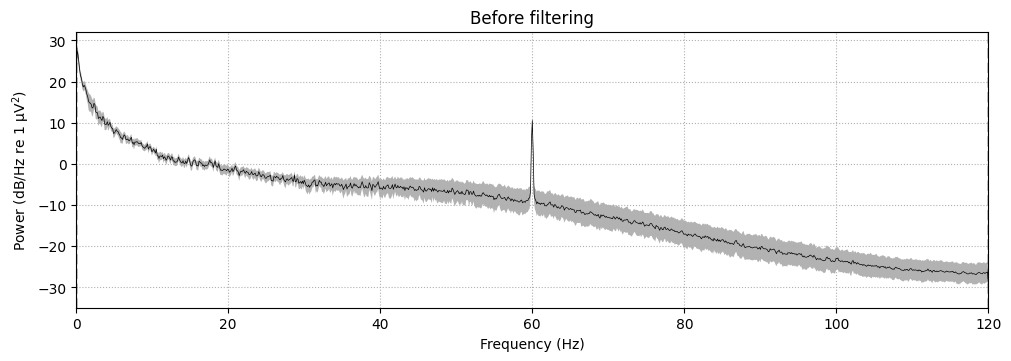

In [11]:
## https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#

# 1. Visualize Data BEFORE Filtering (Power Spectral Density)
# Compute and plot the Power Spectral Density (PSD) of the raw data
# to observe the frequency content before any filtering (e.g., raw.compute_psd().plot()).

fig_1=raw.compute_psd().plot(average=True, amplitude=False)
plt.title('Before filtering')


In [12]:
# 2. Apply Band-pass Filter
# Apply a band-pass filter to the raw data (e.g., 0.1Hz - 20Hz) to remove unwanted frequencies.
# Consider using an FIR filter design (e.g., raw.filter(l_freq=..., h_freq=..., fir_design='firwin')).

filtered_raw=raw.copy().filter(l_freq=0.1, h_freq=20,fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)



In [13]:
# 3. Downsample the Data
# Downsample the data to a lower sampling rate (e.g., from 240Hz to 120Hz).
# MNE's resample function automatically handles anti-aliasing (e.g., raw.resample(sfreq=...)).

downsampled_raw=filtered_raw.copy().resample(sfreq=120)

Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


Text(0.5, 1.0, 'After filtering')

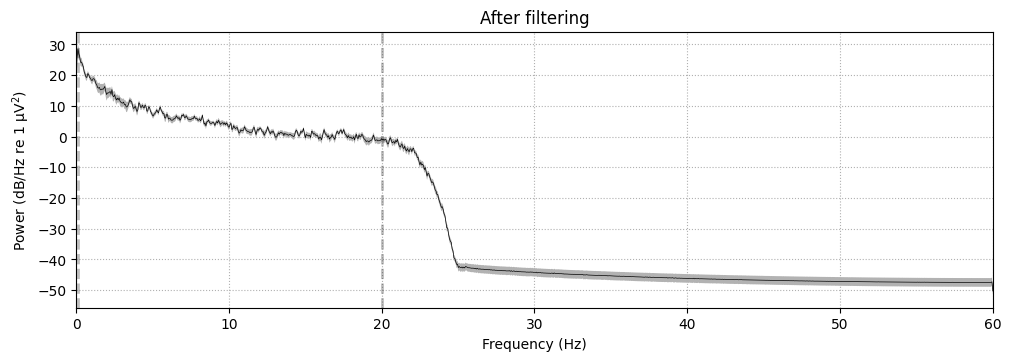

In [14]:
# 4. Visualize Data AFTER Filtering
# Compute and plot the PSD of the filtered and downsampled data
# to verify the effectiveness of the filtering (e.g., raw.compute_psd().plot()).

fig_2=downsampled_raw.compute_psd().plot(average=True, amplitude=False)
plt.title('After filtering')

Using matplotlib as 2D backend.


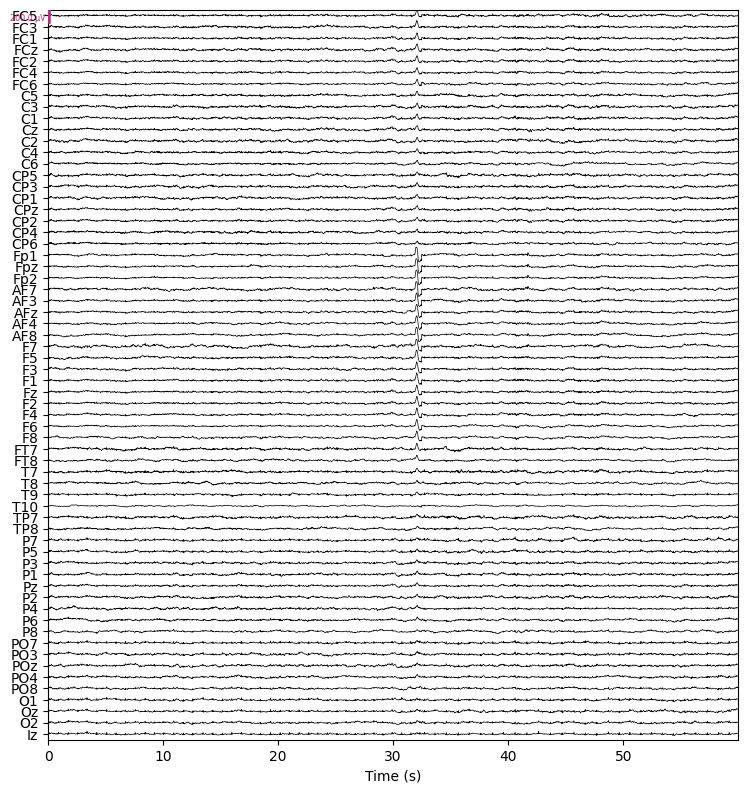

In [15]:
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#
# 1. Assign Standard Channel Names and Montage
# The initial channel names might be generic (e.g., EEG_1, EEG_2).
# Rename the EEG channels to standard names (e.g., 'FC5', 'Cz', 'Pz')
# that correspond to a known montage (e.g., 'standard_1005' or 'standard_1020').
# This is crucial for visualizing components topologically.
# Then, set a standard montage using mne.channels.make_standard_montage.

eeg_electrode_mapping = {
    "EEG_1": "FC5", "EEG_2": "FC3", "EEG_3": "FC1", "EEG_4": "FCz", "EEG_5": "FC2", "EEG_6": "FC4", "EEG_7": "FC6",
    "EEG_8": "C5", "EEG_9": "C3", "EEG_10": "C1", "EEG_11": "Cz", "EEG_12": "C2", "EEG_13": "C4", "EEG_14": "C6",
    "EEG_15": "CP5", "EEG_16": "CP3", "EEG_17": "CP1", "EEG_18": "CPz", "EEG_19": "CP2", "EEG_20": "CP4", "EEG_21": "CP6",
    "EEG_22": "Fp1", "EEG_23": "Fpz", "EEG_24": "Fp2", "EEG_25": "AF7", "EEG_26": "AF3", "EEG_27": "AFz", "EEG_28": "AF4", "EEG_29": "AF8",
    "EEG_30": "F7", "EEG_31": "F5", "EEG_32": "F3", "EEG_33": "F1", "EEG_34": "Fz", "EEG_35": "F2", "EEG_36": "F4", "EEG_37": "F6", "EEG_38": "F8",
    "EEG_39": "FT7", "EEG_40": "FT8", "EEG_41": "T7", "EEG_42": "T8", "EEG_43": "T9", "EEG_44": "T10",
    "EEG_45": "TP7", "EEG_46": "TP8", "EEG_47": "P7", "EEG_48": "P5", "EEG_49": "P3", "EEG_50": "P1", "EEG_51": "Pz", "EEG_52": "P2",
    "EEG_53": "P4", "EEG_54": "P6", "EEG_55": "P8", "EEG_56": "PO7", "EEG_57": "PO3", "EEG_58": "POz", "EEG_59": "PO4", "EEG_60": "PO8",
    "EEG_61": "O1", "EEG_62": "Oz", "EEG_63": "O2", "EEG_64": "Iz"
}

copy_raw=downsampled_raw.copy()

mne.rename_channels(copy_raw.info, eeg_electrode_mapping)

montage = mne.channels.make_standard_montage('standard_1020')
copy_raw.set_montage(montage)

fig_3 = copy_raw.plot(n_channels=len(copy_raw.info['ch_names']), duration=60, scalings=dict(eeg=100e-6), proj=False, show_scrollbars = False)


In [16]:
# 2. Initialize and Fit ICA
# Initialize an ICA object (e.g., mne.preprocessing.ICA) specifying parameters like n_components and random_state.
# Then, fit the ICA model to the raw data, often applying a high-pass filter (>1Hz) for better component separation.
# (Example: ica.fit(raw, reject=dict(eeg=...)))

ica = mne.preprocessing.ICA(n_components=.95, random_state=97)

raw_for_ica = copy_raw.copy().filter(l_freq=1., h_freq=None, fir_design='firwin', verbose=False)

ica.fit(raw_for_ica, reject=dict(eeg=250e-6))


Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
Artifact detected in [3840, 4080]
    Rejecting  epoch based on EEG : ['Fp2', 'AF7']
Artifact detected in [15360, 15600]
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
Artifact detected in [19920, 20160]
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF8']
Artifact detected in [23280, 23520]
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
Artifact detected in [30960, 31200]
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7']
Artifact detected in [34800, 35040]
    Rejecting  epoch based on EEG : ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,54 iterations on raw data (310800 samples)
ICA components,38
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


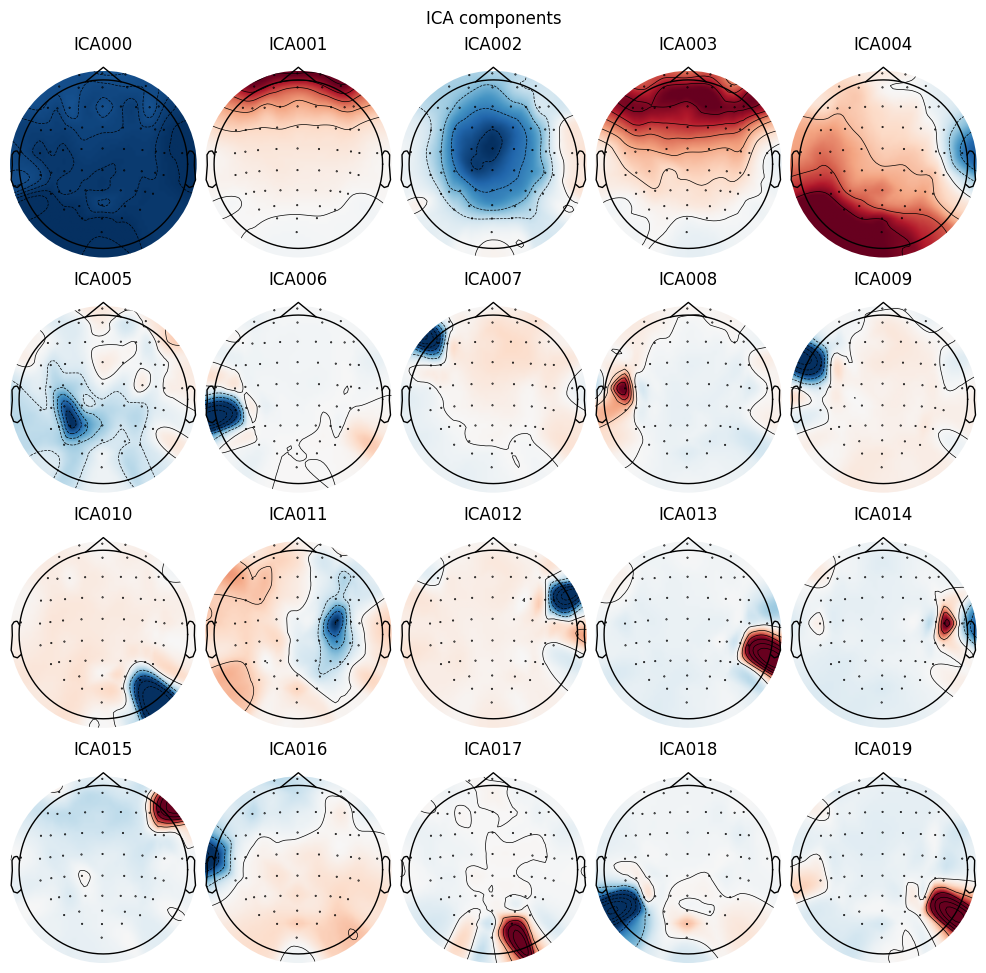

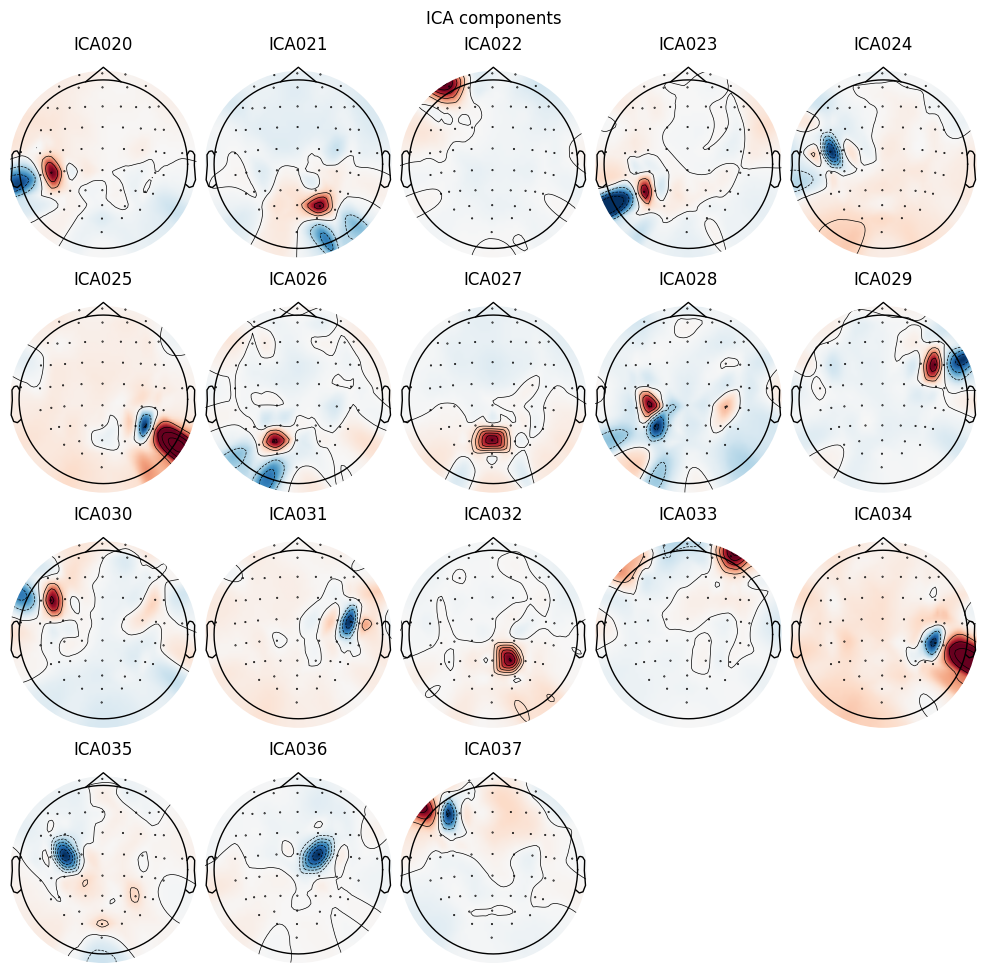

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x967 with 18 Axes>]

In [17]:
# 3. Plot ICA Components
# After fitting, plot the ICA components to visually inspect them for artifacts like eye blinks or muscle activity.
# (Example: ica.plot_components())
ica.plot_components()

From the above scalp topography, it is clear that 1st and 3rd are artifacts from the eye movements and 0th one is from slow drift

In [18]:

# 1. Identify and Exclude Artifact Components
# Based on visual inspection of the ICA components (from the previous step),
# identify components that clearly represent artifacts (e.g., eye blinks, eye movements, muscle activity).
# Then, set the 'exclude' attribute of the ICA object with the indices of these artifact components.

artifact_components = [0, 1, 3]
ica.exclude = artifact_components

In [19]:
# 2. Apply ICA to Remove Artifacts
# Apply the trained ICA model with the excluded components to the raw data.
# This will project the data back into sensor space with the identified artifact components removed.
# (Example: ica.apply(raw))

ica.apply(raw_for_ica)

Applying ICA to Raw instance
    Transforming to ICA space (38 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 331245 (2760.4 s), ~161.8 MiB, data loaded>

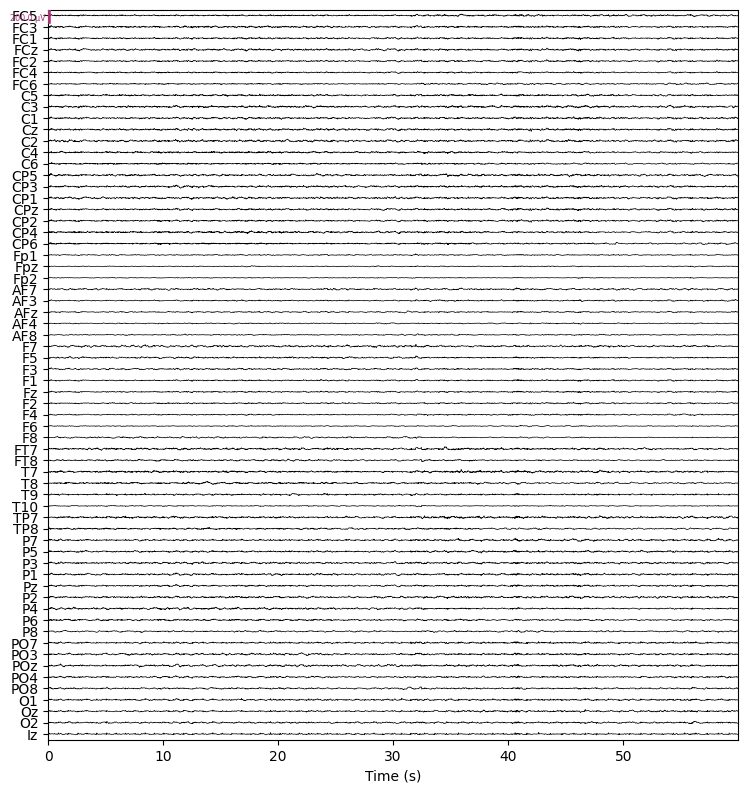

In [20]:
# 3. Visualize Clean Data
# To verify the artifact removal, plot a segment of the cleaned raw data.
# Observe if the previously identified artifacts (like large eye blinks) have been successfully suppressed.
# (Example: raw.plot(n_channels=..., duration=..., title='Data AFTER removing Blinks'))


fig_4 = raw_for_ica.plot(n_channels=len(raw_for_ica.info['ch_names']), duration=60, scalings=dict(eeg=100e-6), proj=False, show_scrollbars = False)

In [33]:
# 1. Prepare Events for Epoching
# Load and process the 'StimulusType' data to assign labels (e.g., Target/Non-Target)
# to the event onsets identified earlier. Create a new MNE-compatible events array
# where the third column represents the event ID (e.g., 1 for Non-Target, 2 for Target).
# Ensure the event IDs are integers.

st=mat_data["StimulusType"]

new_st=pd.DataFrame(st).stack().reset_index(drop=True).to_frame().T

new_event_arr=event_arr.copy()
new_event_arr=new_event_arr.astype('int32')

for i in range(len(new_event_arr)):
  x=new_event_arr[i,0]
  if new_st.iloc[0,int(x)]==1:
    new_event_arr[i,2]=2
  else:
    new_event_arr[i,2]=1
print(new_event_arr)


[[     0      0      1]
 [    42      0      1]
 [    84      0      1]
 ...
 [662130      0      1]
 [662172      0      2]
 [662214      0      1]]


In [22]:
# 2. Define Event IDs Dictionary
# Create a dictionary mapping descriptive event names (e.g., 'Non-Target', 'Target') to their corresponding integer IDs.

event_id = {'Non-Target': 1, 'Target': 2}

In [34]:
# 3. Create Epochs
# Use mne.Epochs to segment the continuous raw data around the events.
# Define the epoch time window (e.g., tmin, tmax), set a baseline correction,
# and preload the data into memory.

epochs = mne.Epochs(raw_for_ica, new_event_arr, event_id = event_id, tmin = -0.1, tmax = 0.8, baseline = (-0.1, 0), preload = True, verbose = False)


print(f"Number of epochs created: {len(epochs)}")
print(epochs)


Number of epochs created: 7650
<Epochs | 7650 events (all good), -0.1 – 0.8 s (baseline -0.1 – 0 s), ~407.2 MiB, data loaded,
 'Non-Target': 6375
 'Target': 1275>


In [36]:
# 4. Compute Evoked Responses
# Compute the average evoked potentials for each event type (e.g., 'Target' and 'Non-Target')
# using the epochs object.

evoc_target = epochs['Target'].average()
evoc_nontarget = epochs['Non-Target'].average()

print(evoc_target)
print(evoc_nontarget)

<Evoked | 'Target' (average, N=1275), -0.1 – 0.8 s, baseline -0.1 – 0 s, 64 ch, ~130 KiB>
<Evoked | 'Non-Target' (average, N=6375), -0.1 – 0.8 s, baseline -0.1 – 0 s, 64 ch, ~130 KiB>


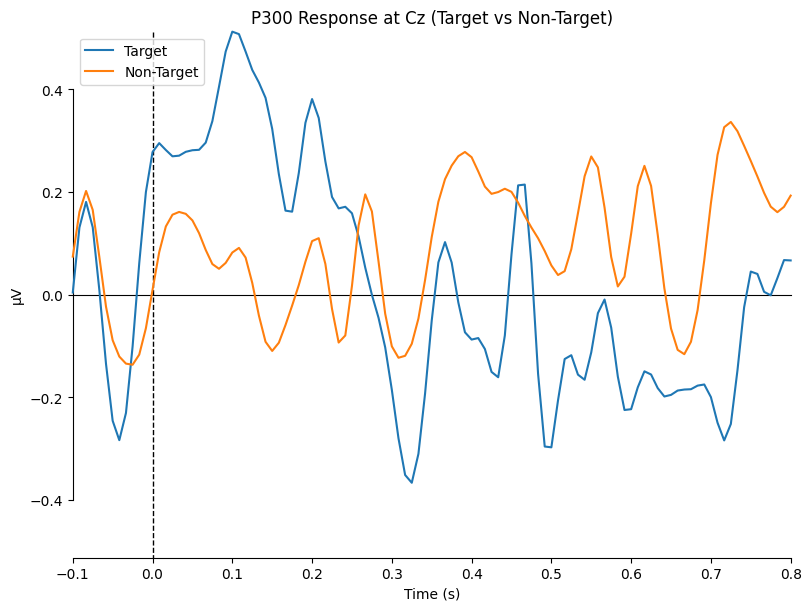

In [37]:
# 5. Visualize the P300 Response
# Plot the averaged evoked responses, typically focusing on a central parietal electrode like 'Cz' or 'Pz',
# to look for the characteristic P300 component (a positive deflection around 300ms post-stimulus).
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Cz')

mne.viz.plot_compare_evokeds({'Target': evoc_target, 'Non-Target': evoc_nontarget}, picks='Cz', title='P300 Response at Cz (Target vs Non-Target)', show_sensors=False)
plt.show()



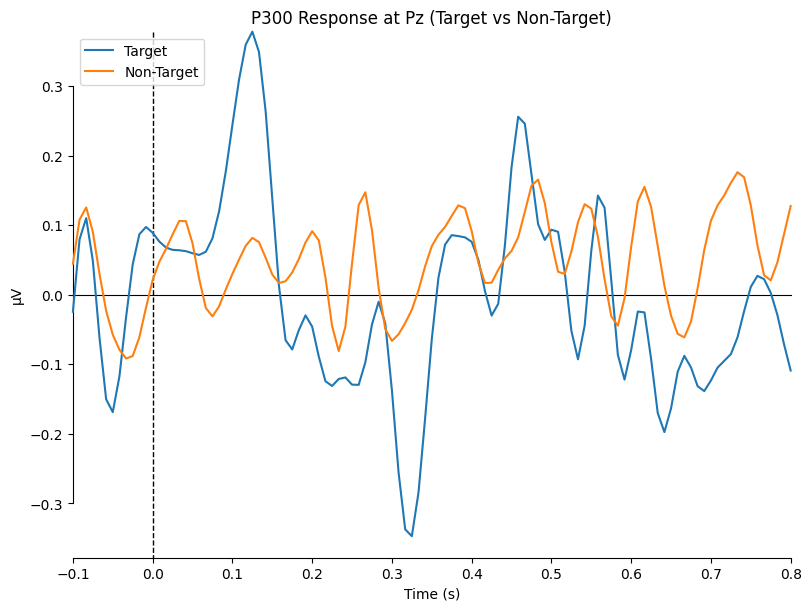

In [38]:

# 1. Compare Evokeds at Pz
# In addition to Cz, plot the evoked responses at channel 'Pz' (Parietal-central)
# as the P300 component is often prominently observed there.
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Pz')

mne.viz.plot_compare_evokeds({'Target': evoc_target, 'Non-Target': evoc_nontarget}, picks='Pz', title='P300 Response at Pz (Target vs Non-Target)', show_sensors=False)
plt.show()